In [1]:
import os
import sys

sys.path.append('..')

from src.mutation import Mutation
from src.sequence import Plasmid
from src.eblocks import Eblock, EblockDesign
from src.primer import DesignPrimers
from src.plot import Plot
from src.utils import Utils, SnapGene

%reload_ext autoreload
%autoreload 2

In [ ]:
# # TODO Make a test script for running everything

# Check if output dir is empty
# Make random mutations
# run eblocks design and primer design
# Do this with the CLI and write explanation in test directory

In [24]:
# TODO Make a script to parse the codon usage of another species and include in the software here. in a tutorial form

In [25]:
# Create a Mutation object and parse the input mutations from the files/ directory

mutations_file = 'files/mutations.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12.txt'
# mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_2.txt'
# mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_3.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_4.txt'

mutation_instance = Mutation()
mutation_instance.parse_mutations(mutations_file)

# Print the mutations that were parsed

mutation_instance.print_mutations()

The selected mutations are:
	Mutation  	V35Y      
	Mutation  	T84Y      
	Insert    	R204-FTSMM
	Mutation  	S251R     
	Combined  	S267M, D276I, D304L
	Combined  	S267M, D276I, D304L, S251R
	Combined  	S267K, D276R, D304S, S251T
	Deletion  	S285-Q294 
	Mutation  	D326M     
	Mutation  	A327G     
	Mutation  	I352C     
	Mutation  	P380Y     
	Mutation  	R416H     
	Mutation  	D428G     
	Mutation  	Y507V     
	Insert    	G535-DDVIIC
	Mutation  	E556R     
	Combined  	N593I, L639S, G635L, S616V
	Combined  	N593G, L639K, G635G, S616T
	Mutation  	D611G     
	Mutation  	P694P     
	Mutation  	Q716L     
	Mutation  	V867L     
	Deletion  	A899-V904 
	Mutation  	L1002K    
	Mutation  	L1052E    
	Mutation  	F1061T    
	Mutation  	V1084M    
	Mutation  	L1157T    


In [26]:
# Create a Plasmid object and parse the input plasmid from the files/ directory

sequence_file = 'files/A0QX55.fasta'
vector_file = 'files/vector.dna'

sequence_instance = Plasmid()
sequence_instance.parse_sequence(sequence_file)
sequence_instance.parse_vector(vector_file)

In [27]:
# Create a SnapGene instance to write the eBlocks features to a snapgene file

# Set output directory
output_dir = 'output'

snapgene_instance = SnapGene(sequence_instance=sequence_instance,
                             output_dir=output_dir)

In [28]:
# Create an Eblocks object based on the input mutations and the gene sequence

# Print some information about the processes
verbose = True  # TODO

design_instance = EblockDesign(mutation_instance=mutation_instance,
                               sequence_instance=sequence_instance,
                               output_dir=output_dir)

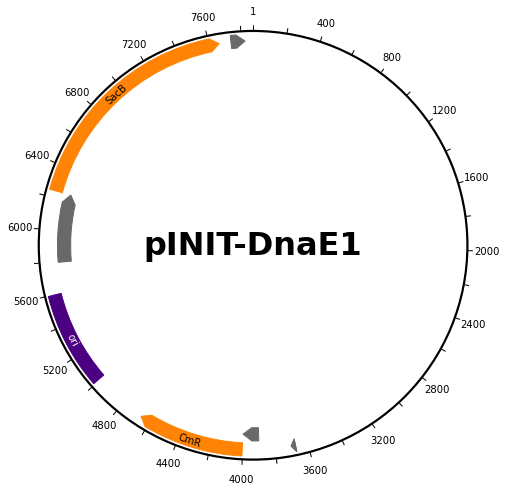

In [29]:
# Create a Plots object and check the input vector

# Create the Plot object
plot_instance = Plot(mutation_instance=mutation_instance,
                     eblocks_design_instance=design_instance,
                     sequence_instance=sequence_instance,
                     output_dir=output_dir)

# Check the input vector
plot_instance.plot_vector(figsize=(7, 7));

# TODO Show eBlocks in vector as well

In [30]:
# TODO Add plasmid visaulization of eBlock features


# from Bio import SeqIO
# from Bio.Graphics import GenomeDiagram
# from Bio.SeqFeature import SeqFeature, FeatureLocation

# # Parse the plasmid sequence
# plasmid_seq_record = SeqIO.read("plasmid_sequence.fasta", "fasta")

# # Create a GenomeDiagram object
# gd_diagram = GenomeDiagram.Diagram("Plasmid Map")

# # Add the sequence track
# gd_track = gd_diagram.new_track(1, name="Plasmid")
# gd_feature_set = gd_track.new_set()

# # Add the plasmid sequence
# gd_feature_set.add_feature(SeqFeature(FeatureLocation(0, len(plasmid_seq_record))), color="black")

# # Parse the GFF3 file to extract features
# # Assuming you have a function parse_gff3() that returns feature information
# features = parse_gff3("plasmid_features.gff3")

# # Add the features to the plasmid map
# for feature in features:
#     start = feature.start
#     end = feature.end
#     name = feature.attributes["Name"]
#     gd_feature_set.add_feature(SeqFeature(FeatureLocation(start, end)), color="blue", label=True, label_position="middle", label_size=8, label_angle=0, label_strand=0, name=name)

# # Draw the plasmid map
# gd_diagram.draw(format="linear", pagesize=(15*len(plasmid_seq_record), 400), fragments=1)
# gd_diagram.write("plasmid_map.png", "png")


In [31]:
# TODO Descibe the vector here, the gene etc

In [32]:
# Now that we have checked our vector, it is time to run the eBlock design process

design_instance.run_design_eblocks()

Starting eBlock design ...
Optimizing based on price per bp ...
Lowest estimated cost: €1910.7 (given price per bp of €0.05)
Completed eBlock design.


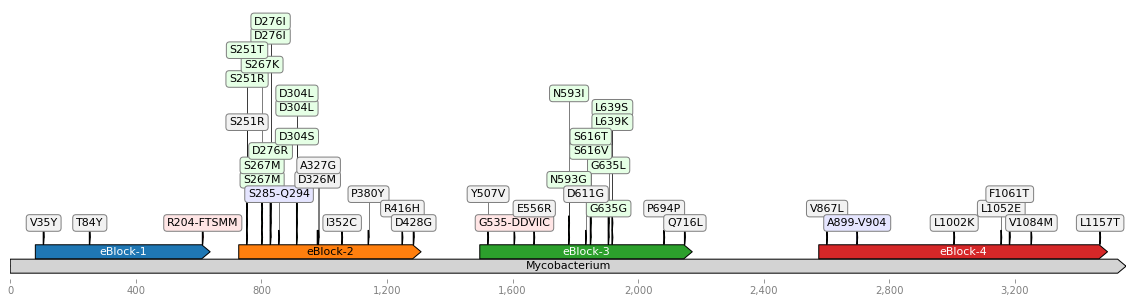

In [33]:
# Now that we have designed the eblocks, we can visualize them using the Plot class

plot_instance.plot_eblocks_mutations(figure_length=20,
                                     figure_width=5)

# TODO Get fixed colorscheme for the eBlocks
# TODO Mycobacterium tuberculosis H37Rv rather than Mycobacterium

In [34]:
# TODO Describe the eblocks here, what you can see with each color etc

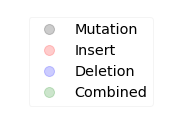

In [35]:
# Each type of mutations (insertions, deletions, substitutions) is represented by a different color, you can see the legend below

plot_instance.plot_mutation_legend()

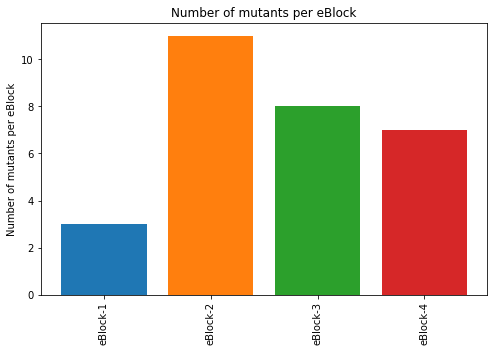

In [36]:
# To see how many mutations can be made in each eBlock, we can plot a histogram

plot_instance.plot_histogram_mutations()

In [37]:
# TODO Do some explanation here

In [38]:
# TODO Save the eblocks to a file

In [39]:
# TODO (At the end of tutorial) Remake the eBlocks but optimize for amount of eBlocks

In [43]:
# Create a primer design object and run the primer design process for IVA primers to amplify the eblocks

primers_instance = DesignPrimers(mutation_instance=mutation_instance,
                                 eblocks_design_instance=design_instance,
                                 sequence_instance=sequence_instance, 
                                 output_dir=output_dir,
                                 snapgene_instance=snapgene_instance)

primers_instance.run_design()

# TODO Save the printed output to a file
# TODO Do not show the data frame here, but save it to a file
# TODO Remove fw_sequence and rv_sequence from df
# TODO Save the begin and end index of the primer on the gene/vector sequence
# TODO Indexes in SnapGene

In [ ]:
# Also design sequencing primers to validate the insertion of the eblocks

primers_instance.run_SEQprimer()

In [ ]:
start_index = 0
occurrences = 0
substring = 'tcatcatcaccaccggatg' # 'ccgaccacggaaacatgttc'
while True:
    # Search for the substring starting from start_index
    index = sequence_instance.vector.seq.find(substring, start_index)
    # If the substring is not found, break the loop
    if index == -1:
        break
    # Increment the count of occurrences
    occurrences += 1
    # Move the start_index to search for the next occurrence
    start_index = index + len(substring)
# Check if multiple occurrences were found
if occurrences > 1:
    print("Multiple occurrences found.")
else:
    print("Only one occurrence found.")

In [ ]:
primers_instance.run_SEQprimer()

In [ ]:
for k, v in design_instance.eblocks.items():
    print(k, v[2], v)

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

# TODO AT THE END OF THE TURORIAL CREATE A PDF WITH ALL THE PLOTS AND THE SEQUENCES

# TODO TRY RUNNING TESTS FROM COMMAND LINE AS WELL AND SEE IF THIS WORKS

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted